<a href="https://colab.research.google.com/github/rgurve/NLP-RoBERTa-with-fastai/blob/main/Using_RoBERTa_with_fast_ai_for_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image.png](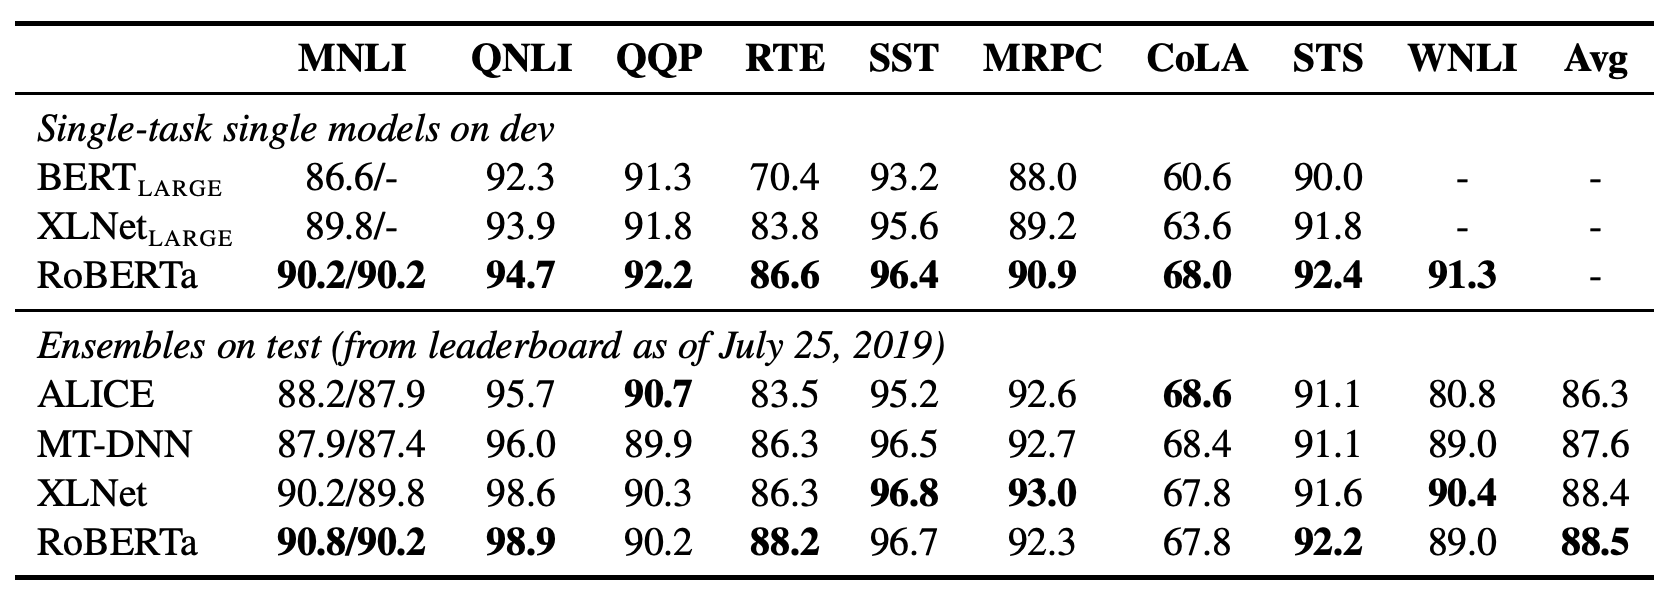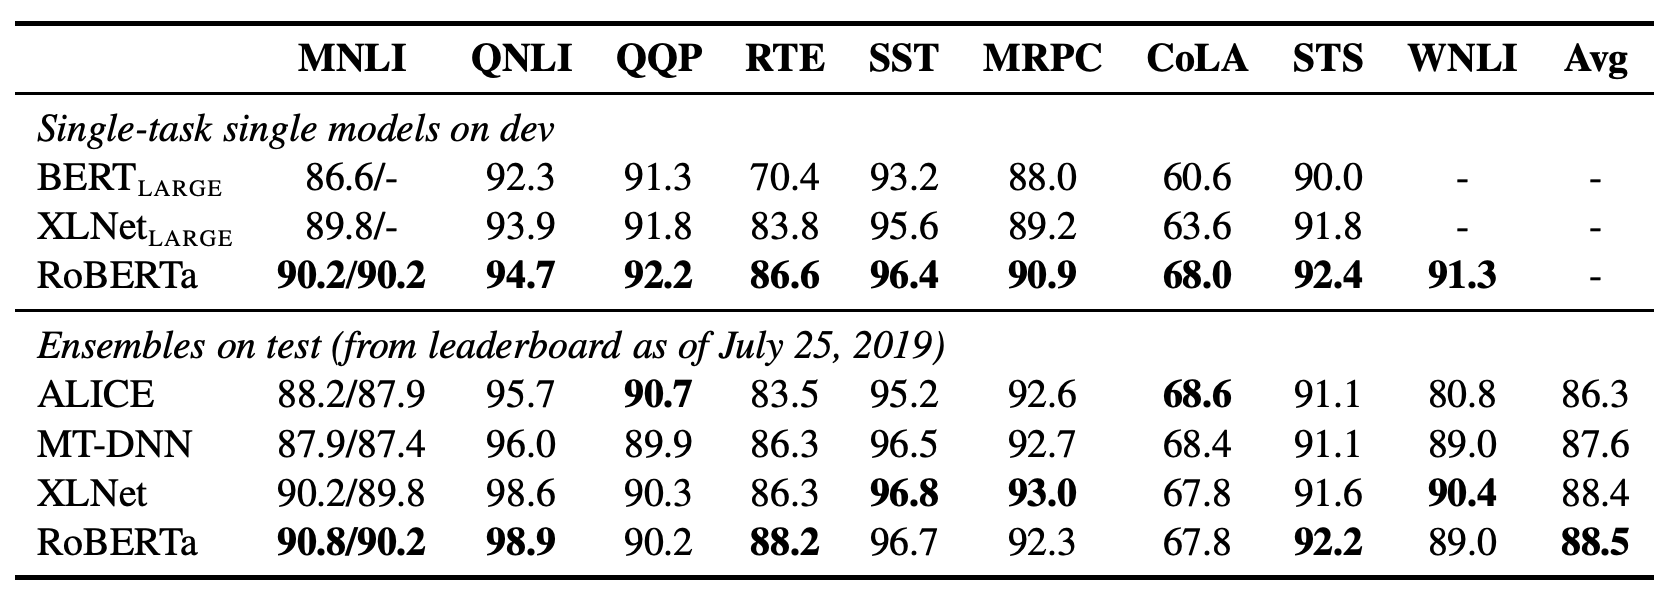)

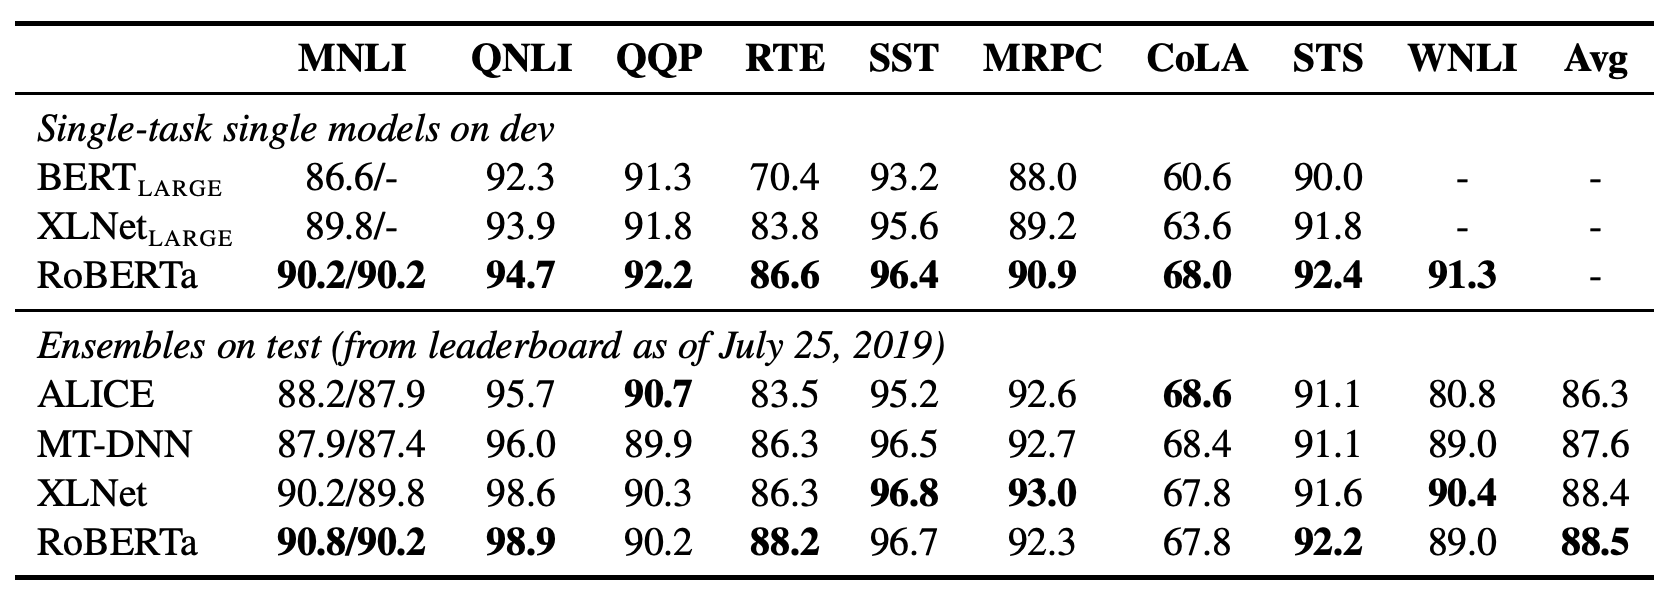

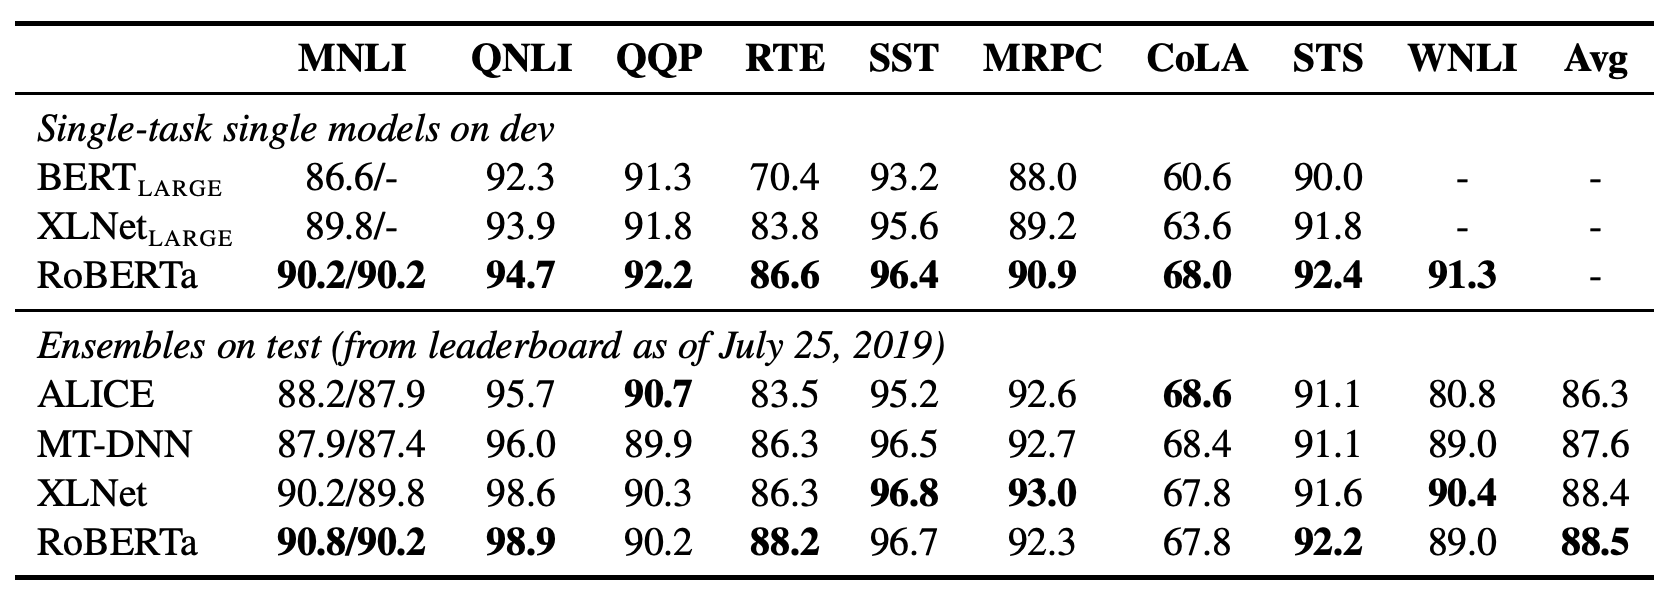

### RoBERTa builds upon BERT by pretraining longer with more data, bigger batch sizes while only pretraining on masked language modeling as opposed to pretraining on next sentence prediction as well. The underlying architecture remains unchanged as both utilize masked language model pretraining.

In [21]:
!pip install transformers


### Setting up the Tokenizer

Importing files

In [22]:
from fastai.text import *
from fastai.metrics import *

Importing Roberta Tokenizer

In [23]:
from transformers import RobertaTokenizer
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

RoBERTa uses different default special tokens from BERT. For example, instead of [CLS] and [SEP] for starting and ending tokens, <s> and </s> are used respectively. For example, a tokenized movie review may look like:
“the movie was great” → [<s>, the, Ġmovie, Ġwas, Ġgreat, </s>]
We will now create a Fastai wrapper around RobertaTokenizer

In [24]:
class FastAiRobertaTokenizer(BaseTokenizer):
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        return ["<s>"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["</s>"]

Now, we can initialize our Fastai tokenizer: (Note: we have to wrap our Fastai wrapper within the Tokenizer class for Fastai compatibility)


In [25]:
fastai_tokenizer = Tokenizer(tok_func = FastAiRobertaTokenizer(roberta_tok, max_seq_len=256), pre_rules=[], post_rules=[])

Next, we will load Roberta’s vocabulary.

In [26]:
path = Path()
roberta_tok.save_vocabulary(path) 
with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))


### Setting up the Databunch

Before we can build our Fastai DataBunch, we need to create appropriate pre-processors for the tokenizer and vocabulary.


In [27]:
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)
         
class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)
        
def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

Now, we will create a DataBunch class specifically for Roberta.

In [28]:
class RobertaDataBunch(TextDataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

And lastly, we will also need a Roberta specific TextList class:


In [29]:
class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList


### Loading the Data

Now that we have finished the involving set up process, we can bring it all together to read in our IMDB data.

In [12]:
!unzip IMDB\ Dataset.csv.zip

Archive:  IMDB Dataset.csv.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [13]:
df = pd.read_csv("IMDB Dataset.csv")
feat_cols = "review"
label_cols = "sentiment"

We can now simply create create a Fastai DataBunch with:


In [14]:
processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)
data = RobertaTextList.from_df(df, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(seed=2019) \
    .label_from_df(cols=label_cols,label_cls=CategoryList) \
    .databunch(bs=4, pad_first=False, pad_idx=0)


/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


### Building a Custom Roberta Model


In this step, we will define the model architecture to pass to our Fastai learner. Essentially, we add a new final layer to the output of the RobertaModel. This layer will be trained specifically for the IMDB sentiment classification.

In [15]:
import torch
import torch.nn as nn
from transformers import RobertaModel

class CustomRobertatModel(nn.Module):
    def __init__(self,num_labels=2):
        super(CustomRobertatModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.dropout = nn.Dropout(.05)
        self.classifier = nn.Linear(768, num_labels)
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask)
        logits = self.classifier(pooled_output)        
        return logits

Initialize the model:

In [16]:
roberta_model = CustomRobertatModel()

## Train the Model

In [17]:
learn = Learner(data, roberta_model, metrics=[accuracy])


Start training:

In [18]:
!pip install transformers==3.0.0

In [19]:
learn = Learner(data, roberta_model, metrics=[accuracy])

In [20]:
# set roberta into train mode
learn.model.roberta.train() 
learn.fit_one_cycle(1, max_lr=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.203041,0.154313,0.940600,36:15


After only a single epoch and without unfreezing layers, we achieve an accuracy of 94% on the validation set.


In [20]:
# find an appropriate lr
learn.lr_find()
learn.recorder.plot()
# unfreeze layers
learn.unfreeze()
# train using half precision
learn = learn.to_fp16()

### Creating Predictions

Since predictions are not outputted in order by Fastai’s get_preds function, we can use the following method.


In [30]:
def get_preds_as_nparray(ds_type) -> np.ndarray:

    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values
# For Valid
preds, pred_values = get_preds_as_nparray(DatasetType.Valid)


Note: if we had a test set, we could have easily added a test set during step 3 earlier by initializing “data” like this:


In [ ]:
data = RobertaTextList.from_df(df, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(seed=2019) \
    .label_from_df(cols=label_cols,label_cls=CategoryList) \
    .add_test(RobertaTextList.from_df(test_df, ".", cols=feat_cols, processor=processor)) \
    .databunch(bs=4, pad_first=False, pad_idx=0)


Hence, if we had a test set, we could derive preds via:

In [ ]:
test_preds = get_preds_as_nparray(DatasetType.Test)